In [ ]:
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from google.colab import drive
from numpy.random import seed

In [ ]:
drive.mount('/gdrive')
%cd /gdrive/MyDrive/F21DL_CW2/Data/CSV

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/MyDrive/F21DL_CW2/Data/CSV


In [ ]:
X_train = pd.read_csv('x_train_gr_smpl.csv')
X_test = pd.read_csv('x_test_gr_smpl.csv')

X = pd.concat([X_train, X_test]).reset_index().drop(columns = ['index'])

y_train = pd.read_csv('y_train_smpl.csv')
y_test = pd.read_csv('y_test_smpl.csv')

y = pd.concat([y_train, y_test]).reset_index().drop(columns = ['index'])

X_train_4000, X_test_4000, y_train_4000, y_test_4000 = train_test_split(X, y, test_size=0.55, random_state=42, stratify = y)
X_train_9000, X_test_9000, y_train_9000, y_test_9000 = train_test_split(X, y, test_size=0.95, random_state=42, stratify = y)

X_train_4000 = X_train_4000.reset_index().drop(columns = ['index'])
X_test_4000 = X_test_4000.reset_index().drop(columns = ['index'])
y_train_4000 = y_train_4000.reset_index().drop(columns = ['index'])
y_test_4000 = y_test_4000.reset_index().drop(columns = ['index'])

X_train_9000 = X_train_9000.reset_index().drop(columns = ['index'])
X_test_9000 = X_test_9000.reset_index().drop(columns = ['index'])
y_train_9000 = y_train_9000.reset_index().drop(columns = ['index'])
y_test_9000 = y_test_9000.reset_index().drop(columns = ['index'])

X_train_tensor = tf.reshape(np.array(X_train), shape = (9690, 48, 48, 1))
X_test_tensor = tf.reshape(np.array(X_test), shape = (3090, 48, 48, 1))
X_train_4000_tensor = tf.reshape(np.array(X_train_4000), shape = (5750, 48, 48, 1))
X_test_4000_tensor = tf.reshape(np.array(X_test_4000), shape = (7030, 48, 48, 1))
X_train_9000_tensor = tf.reshape(np.array(X_train_9000), shape = (639, 48, 48, 1))
X_test_9000_tensor = tf.reshape(np.array(X_test_9000), shape = (12141, 48, 48, 1))

In [ ]:
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state = 42)
es = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10, min_delta = 0.00001, mode = 'min', restore_best_weights = True)
seed(42)

In [ ]:
adm = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)

In [ ]:
clf = LogisticRegression(random_state=42).fit(X_train_4000, y_train_4000)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [ ]:
y_pred = clf.predict(X_test_4000)

In [ ]:
cr = pd.DataFrame(classification_report(y_test_4000, y_pred, output_dict=True)).T
auc_p_c = list()

for i in range(10):
  fpr, tpr, _ = roc_curve(np.array(y_test_4000), y_pred, pos_label=i)
  auc_p_c.append(auc(fpr, tpr))

cr['auc'] = auc_p_c + [0, 0, 0]
cr.loc['weighted avg', 'auc'] = (cr.loc[['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], 'auc'] * cr.loc[['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], 'support']).sum() / cr.loc['macro avg', 'support']
cr.loc['macro avg', 'auc'] = (cr.loc[['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], 'auc']).mean()

In [ ]:
cr

,precision,recall,f1-score,support,auc
0,0.873134,0.785235,0.826855,149.000000,0.058241
1,0.899939,0.906617,0.903266,1617.000000,0.073828
2,0.917892,0.907879,0.912858,1650.000000,0.330094
3,0.959204,0.942326,0.950690,1023.000000,0.556683
4,0.929341,0.951102,0.940095,1452.000000,0.764675
5,0.902597,0.939189,0.920530,148.000000,0.853150
6,0.826568,0.903226,0.863198,248.000000,0.861567
7,0.928105,0.860606,0.893082,165.000000,0.883302
8,0.951841,0.884211,0.916780,380.000000,0.954616
9,0.830986,0.893939,0.861314,198.000000,0.979453


In [ ]:
cfbase = pd.DataFrame(np.array(tf.math.confusion_matrix(y_test_4000, y_pred_bool)))

No handles with labels found to put in legend.


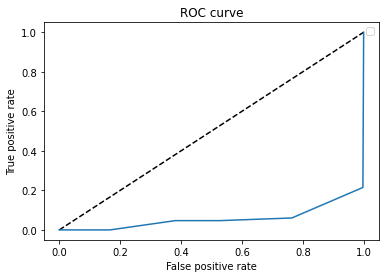

No handles with labels found to put in legend.


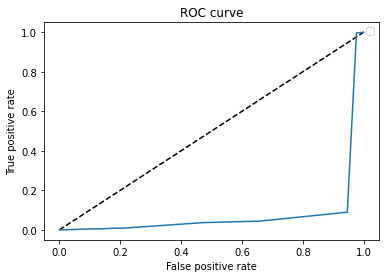

No handles with labels found to put in legend.


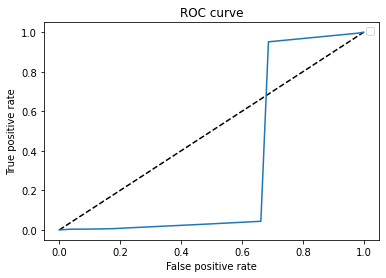

No handles with labels found to put in legend.


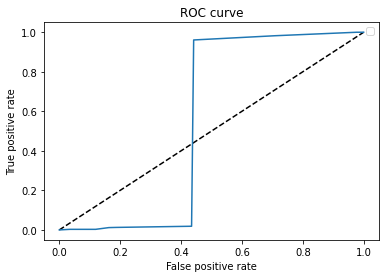

No handles with labels found to put in legend.


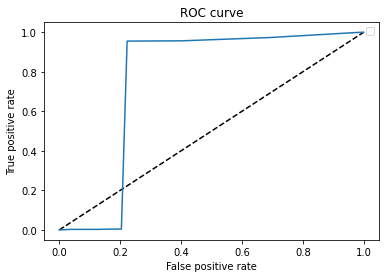

No handles with labels found to put in legend.


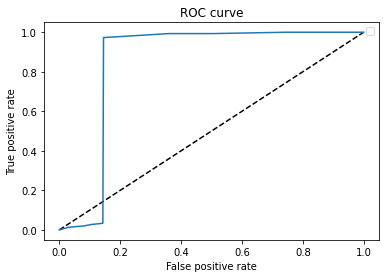

No handles with labels found to put in legend.


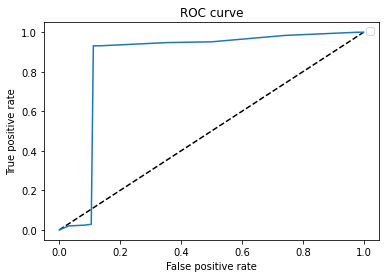

No handles with labels found to put in legend.


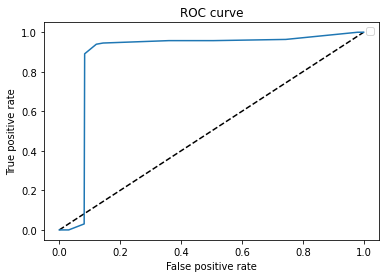

No handles with labels found to put in legend.


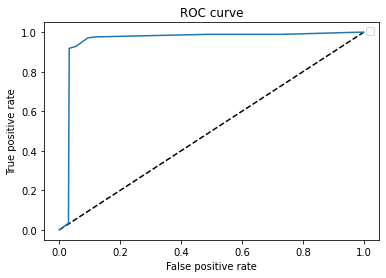

No handles with labels found to put in legend.


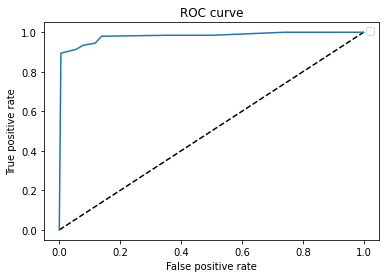

In [ ]:
for i in range(10):
  fpr, tpr, _ = roc_curve(np.array(y_test_4000), y_pred, pos_label=i)
  auc_p_c.append(auc(fpr, tpr))

  plt.figure(1)
  plt.plot([0, 1], [0, 1], 'k--')
  plt.plot(fpr, tpr)#, label='Keras (area = {:.3f})'.format(auc))
  # plt.plot(fpr_rf, tpr_rf, label='RF (area = {:.3f})'.format(auc_rf))
  plt.xlabel('False positive rate')
  plt.ylabel('True positive rate')
  plt.title('ROC curve')
  plt.legend(loc='best')
  plt.show()

In [ ]:
model_1 = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(64, (4,4), activation='relu', input_shape=(48, 48, 1)),
  tf.keras.layers.MaxPooling2D(3, 3),
  tf.keras.layers.Conv2D(64, (4,4), activation='relu'),
  tf.keras.layers.MaxPooling2D(3,3),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(512, activation='relu'),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(10, activation='softmax')
])

In [ ]:
model_2 = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(128, (3,3), activation='relu', input_shape=(48, 48, 1)),
  tf.keras.layers.MaxPooling2D(3, 3),
  tf.keras.layers.Conv2D(256, (3,3), activation='relu'),
  tf.keras.layers.MaxPooling2D(3,3),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(1024,activation='relu'),
  tf.keras.layers.Dense(512, activation='relu'),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(10, activation='softmax')
])

In [ ]:
model_3 = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(128, (3,3), activation='relu', input_shape=(48, 48, 1)),
  tf.keras.layers.MaxPooling2D(3, 3),
  tf.keras.layers.Conv2D(256, (3,3), activation='relu'),
  tf.keras.layers.MaxPooling2D(3,3),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(512, activation='relu'),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(10, activation='softmax')
])

In [ ]:
model_4 = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(64, (4,4), activation='relu', input_shape=(48, 48, 1)),
  tf.keras.layers.MaxPooling2D(2, 2),
  tf.keras.layers.Conv2D(128, (4,4), activation='relu'),
  tf.keras.layers.MaxPooling2D(2,2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(2048, activation='relu'),
  tf.keras.layers.Dense(1024, activation='relu'),
  tf.keras.layers.Dense(512, activation='relu'),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(10, activation='softmax')
])

In [ ]:
model_5 = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(64, (4,4), activation='relu', input_shape=(48, 48, 1)),
  tf.keras.layers.MaxPooling2D(3, 3),
  tf.keras.layers.Conv2D(64, (4,4), activation='relu'),
  tf.keras.layers.MaxPooling2D(3,3),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(1024, activation='relu'),
  tf.keras.layers.Dense(512, activation='relu'),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(10, activation='softmax')
])

In [ ]:
model_1.compile(optimizer=adm, loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [ ]:
model_2.compile(optimizer=adm, loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [ ]:
model_3.compile(optimizer=adm, loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [ ]:
model_4.compile(optimizer=adm, loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [ ]:
model_5.compile(optimizer=adm, loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [ ]:
model_1.fit(x=X_train_4000_tensor,y=y_train_4000,epochs=300, callbacks = [es], verbose = 1)

In [ ]:
model_2.fit(x=X_train_4000_tensor,y=y_train_4000,epochs=300, callbacks = [es], verbose = 1)

In [ ]:
model_3.fit(x=X_train_4000_tensor,y=y_train_4000,epochs=300, callbacks = [es], verbose = 1)

In [ ]:
model_4.fit(x=X_train_4000_tensor,y=y_train_4000,epochs=300, callbacks = [es], verbose = 1)

In [ ]:
model_5.fit(x=X_train_4000_tensor,y=y_train_4000,epochs=300, callbacks = [es], verbose = 1)

In [ ]:
model_1.evaluate(X_test_4000_tensor, y_test_4000)

220/220 [==============================] - 1s 2ms/step - loss: 0.1133 - accuracy: 0.9797


[0.1133129894733429, 0.9796586036682129]

In [ ]:
model_2.evaluate(X_test_4000_tensor, y_test_4000)

220/220 [==============================] - 1s 3ms/step - loss: 1.9134 - accuracy: 0.2300


[1.9133814573287964, 0.23001421988010406]

In [ ]:
model_3.evaluate(X_test_4000_tensor, y_test_4000)

220/220 [==============================] - 1s 3ms/step - loss: 0.2542 - accuracy: 0.9744


[0.25416722893714905, 0.9743954539299011]

In [ ]:
model_4.evaluate(X_test_4000_tensor, y_test_4000)

220/220 [==============================] - 1s 3ms/step - loss: 1.9120 - accuracy: 0.2300


[1.9119901657104492, 0.23001421988010406]

In [ ]:
model_5.evaluate(X_test_4000_tensor, y_test_4000)

220/220 [==============================] - 1s 2ms/step - loss: 1.9136 - accuracy: 0.2347


[1.913633108139038, 0.23470839858055115]

In [ ]:
model_cnn_basic = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(128, (4,4), activation='relu', input_shape=(48, 48, 1)),
  tf.keras.layers.MaxPooling2D(3, 3),
  tf.keras.layers.Conv2D(128, (4,4), activation='relu'),
  tf.keras.layers.MaxPooling2D(3,3),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(512, activation='relu'),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(10, activation='softmax')
])

In [ ]:
model_cnn_basic.compile(optimizer=adm, loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [ ]:
model_cnn_basic.fit(x=X_train_4000_tensor,y=y_train_4000,epochs=300, callbacks = [es], verbose = 1)

In [ ]:
model_cnn_basic.evaluate(X_test_4000_tensor, y_test_4000)

220/220 [==============================] - 1s 3ms/step - loss: 0.6521 - accuracy: 0.9097


[0.652104914188385, 0.9096728563308716]

In [ ]:
%cd final_summary_4000/

/gdrive/My Drive/F21DL_CW2/Data/CSV/final_summary_4000


In [ ]:
y_pred = model_1.predict(X_test_4000_tensor)
y_pred_bool = np.argmax(y_pred, axis=1)

In [ ]:
cr_1 = pd.DataFrame(classification_report(y_test_4000, y_pred_bool, output_dict=True)).T
auc_p_c = list()

for i in range(10):
  fpr, tpr, _ = roc_curve(np.array(y_test_4000), y_pred_bool, pos_label=i)#, sample_weight = np.array(cr_1.loc[['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], 'support']))
  auc_p_c.append(auc(fpr, tpr))

cr_1['auc'] = auc_p_c + [0, 0, 0]
cr_1.loc['weighted avg', 'auc'] = (cr_1.loc[['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], 'auc'] * cr_1.loc[['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], 'support']).sum() / cr_1.loc['macro avg', 'support']
cr_1.loc['macro avg', 'auc'] = (cr_1.loc[['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], 'auc']).mean()

In [ ]:
cf1 = tf.math.confusion_matrix(y_test_4000, y_pred_bool)

In [ ]:
y_pred = model_2.predict(X_test_4000_tensor)
y_pred_bool = np.argmax(y_pred, axis=1)

In [ ]:
cr_2 = pd.DataFrame(classification_report(y_test_4000, y_pred_bool, output_dict=True)).T
auc_p_c = list()

for i in range(10):
  fpr, tpr, _ = roc_curve(np.array(y_test_4000), y_pred_bool, pos_label=i)#, sample_weight = np.array(cr_1.loc[['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], 'support']))
  auc_p_c.append(auc(fpr, tpr))

cr_2['auc'] = auc_p_c + [0, 0, 0]
cr_2.loc['weighted avg', 'auc'] = (cr_2.loc[['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], 'auc'] * cr_2.loc[['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], 'support']).sum() / cr_2.loc['macro avg', 'support']
cr_2.loc['macro avg', 'auc'] = (cr_2.loc[['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], 'auc']).mean()

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
cf2 = tf.math.confusion_matrix(y_test_4000, y_pred_bool)

In [ ]:
y_pred = model_3.predict(X_test_4000_tensor)
y_pred_bool = np.argmax(y_pred, axis=1)

In [ ]:
cr_3 = pd.DataFrame(classification_report(y_test_4000, y_pred_bool, output_dict=True)).T
auc_p_c = list()

for i in range(10):
  fpr, tpr, _ = roc_curve(np.array(y_test_4000), y_pred_bool, pos_label=i)#, sample_weight = np.array(cr_1.loc[['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], 'support']))
  auc_p_c.append(auc(fpr, tpr))

cr_3['auc'] = auc_p_c + [0, 0, 0]
cr_3.loc['weighted avg', 'auc'] = (cr_3.loc[['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], 'auc'] * cr_3.loc[['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], 'support']).sum() / cr_3.loc['macro avg', 'support']
cr_3.loc['macro avg', 'auc'] = (cr_3.loc[['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], 'auc']).mean()

In [ ]:
cf3 = tf.math.confusion_matrix(y_test_4000, y_pred_bool)

In [ ]:
y_pred = model_4.predict(X_test_4000_tensor)
y_pred_bool = np.argmax(y_pred, axis=1)

In [ ]:
cr_4 = pd.DataFrame(classification_report(y_test_4000, y_pred_bool, output_dict=True)).T
auc_p_c = list()

for i in range(10):
  fpr, tpr, _ = roc_curve(np.array(y_test_4000), y_pred_bool, pos_label=i)#, sample_weight = np.array(cr_1.loc[['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], 'support']))
  auc_p_c.append(auc(fpr, tpr))

cr_4['auc'] = auc_p_c + [0, 0, 0]
cr_4.loc['weighted avg', 'auc'] = (cr_4.loc[['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], 'auc'] * cr_4.loc[['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], 'support']).sum() / cr_4.loc['macro avg', 'support']
cr_4.loc['macro avg', 'auc'] = (cr_4.loc[['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], 'auc']).mean()

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
cf4 = tf.math.confusion_matrix(y_test_4000, y_pred_bool)

In [ ]:
y_pred = model_5.predict(X_test_4000_tensor)
y_pred_bool = np.argmax(y_pred, axis=1)

In [ ]:
cr_5 = pd.DataFrame(classification_report(y_test_4000, y_pred_bool, output_dict=True)).T
auc_p_c = list()

for i in range(10):
  fpr, tpr, _ = roc_curve(np.array(y_test_4000), y_pred_bool, pos_label=i)#, sample_weight = np.array(cr_1.loc[['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], 'support']))
  auc_p_c.append(auc(fpr, tpr))

cr_5['auc'] = auc_p_c + [0, 0, 0]
cr_5.loc['weighted avg', 'auc'] = (cr_5.loc[['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], 'auc'] * cr_5.loc[['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], 'support']).sum() / cr_5.loc['macro avg', 'support']
cr_5.loc['macro avg', 'auc'] = (cr_5.loc[['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], 'auc']).mean()

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
cf5 = tf.math.confusion_matrix(y_test_4000, y_pred_bool)

In [ ]:
y_pred = model_cnn_basic.predict(X_test_4000_tensor)
y_pred_bool = np.argmax(y_pred, axis=1)

In [ ]:
cr_basic = pd.DataFrame(classification_report(y_test_4000, y_pred_bool, output_dict=True)).T
auc_p_c = list()

for i in range(10):
  fpr, tpr, _ = roc_curve(np.array(y_test_4000), y_pred_bool, pos_label=i)#, sample_weight = np.array(cr_1.loc[['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], 'support']))
  auc_p_c.append(auc(fpr, tpr))

cr_basic['auc'] = auc_p_c + [0, 0, 0]
cr_basic.loc['weighted avg', 'auc'] = (cr_basic.loc[['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], 'auc'] * cr_basic.loc[['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], 'support']).sum() / cr_basic.loc['macro avg', 'support']
cr_basic.loc['macro avg', 'auc'] = (cr_basic.loc[['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], 'auc']).mean()

In [ ]:
cfbasic = tf.math.confusion_matrix(y_test_4000, y_pred_bool)

In [ ]:
cr.to_csv('cr_baseline.csv')

In [ ]:
cr_1.to_csv('cr_1.csv')
cr_2.to_csv('cr_2.csv')
cr_3.to_csv('cr_3.csv')
cr_4.to_csv('cr_4.csv')
cr_5.to_csv('cr_5.csv')
cr_basic.to_csv('cr_basic.csv')

In [ ]:
pd.DataFrame(np.array(cf1)).to_csv('cf1.csv')
pd.DataFrame(np.array(cf2)).to_csv('cf2.csv')
pd.DataFrame(np.array(cf3)).to_csv('cf3.csv')
pd.DataFrame(np.array(cf4)).to_csv('cf4.csv')
pd.DataFrame(np.array(cf5)).to_csv('cf5.csv')
pd.DataFrame(np.array(cfbasic)).to_csv('cfbasic.csv')
cfbase.to_csv('cfbaseline.csv')

In [ ]:
%ls

sample_data/
